# Multi-Label Classification

### The Data

In [37]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [38]:
df = pd.read_csv(path/'train.csv')
df.head(5)

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [39]:
valid = df[df.is_valid == True]
not_valid = df[df.is_valid == False]

In [40]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [41]:
tmp_df['c'] = np.multiply(tmp_df.a, tmp_df.b)

In [42]:
tmp_df

,a,b,c
0,1,3,3
1,2,4,8


## constructing a DataBlock

In [44]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [45]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [46]:
x, y = dsets.train[0]
x, y

(fname       001436.jpg
 labels       aeroplane
 is_valid         False
 Name: 710, dtype: object,
 fname       001436.jpg
 labels       aeroplane
 is_valid         False
 Name: 710, dtype: object)

In [47]:
def get_x(r): return r.fname
def get_y(r): return r.labels

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

('009018.jpg', 'bird')

In [48]:
def get_x(r): return path/'train'/r.fname
def get_y(r): return r.labels.split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/006304.jpg'), ['boat'])

TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0.])


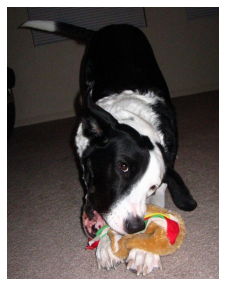

In [52]:
# we need to replace categoryblock with multicategoryblock

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                      get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)
x, y = dsets.train[0]
print(y)
x.show();

In [54]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
print(idxs)
dsets.train.vocab[idxs]

TensorMultiCategory([11])


(#1) ['dog']

In [55]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train, valid

In [56]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                      splitter = splitter,
                      get_x = get_x,
                      get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [57]:
dblock = DataBlock(
            blocks = (ImageBlock, MultiCategoryBlock),
            splitter = splitter,
            get_x = get_x,
            get_y = get_y,
            item_tfms = Resize(500)
)

dls = dblock.dataloaders(df)

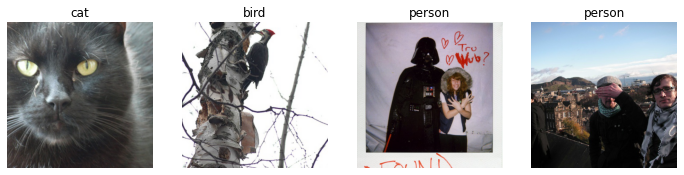

In [17]:
dls.train.show_batch(nrows = 1, ncols=4)

In [18]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

## Binary Cross-Entropy

In [19]:
learn = cnn_learner(dls, resnet18)

In [20]:
nn.Module?

In [21]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [22]:
activs[0]

tensor([ 2.9684, -1.4524, -1.5176,  4.1546,  1.2878,  3.6280, -0.2031, -2.2360,
         0.3462, -2.8663,  2.0451, -3.3546, -2.5163, -0.6435,  0.5166, -0.0473,
         0.3411, -1.9005, -2.8476,  1.3000], grad_fn=<SelectBackward>)

In [23]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs)

In [24]:
binary_cross_entropy(activs, y)[0]

TensorMultiCategory([-0.9511, -0.1896, -0.1798, -0.9846, -0.7838, -0.9741, -0.4494, -0.0966,
        -0.5857, -0.0538, -0.8855, -0.0337, -0.0747, -0.3445, -0.3736, -0.4882,
        -0.5845, -0.1301, -0.0548, -0.7858], grad_fn=<AliasBackward>)

In [25]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0714, grad_fn=<AliasBackward>)

In [26]:
def accuracy_multi(inp, targ, thresh=.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [27]:
from fastai.callback.fp16 import *

In [28]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=.2)).to_fp16()

In [29]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs = 4)

epoch,train_loss,valid_loss,accuracy_multi,time


RuntimeError: CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 7.94 GiB total capacity; 6.88 GiB already allocated; 96.50 MiB free; 7.31 GiB reserved in total by PyTorch)